# Evaluate predictions on HotpotQA
- Model predicts weather a sentence is a supporting fact to answer a question
- This notebook rearranges the predictions and evaluates the performance just like the hotpot evaluation script

In [1]:
import random
import math
import os
import pickle
from tqdm import tqdm, trange
import numpy as np

import sklearn
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

import pdb

In [2]:
import warnings
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [3]:
from pytorch_pretrained_bert import BertTokenizer

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
def pickler(path,pkl_name,obj):
    with open(os.path.join(path, pkl_name), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def unpickler(path,pkl_name):
    with open(os.path.join(path, pkl_name) ,'rb') as f:
        obj = pickle.load(f)
    return obj

In [6]:
data_pkl_path = "../../data/hotpot/"
data_pkl_name = "preprocessed_dev.pkl"
predictions_pkl_path = "./"
predictions_pkl_name = "predictions_4x.pkl"

In [7]:
def exact_match(gt, pred):
    assert(len(gt) == len(pred))
    total_size = len(pred)
    num_correct = 0
    for i in range(total_size):
        if(gt[i] == pred[i]):
            num_correct += 1
    return num_correct/total_size

In [8]:
def evaluate(gt, pred):
    assert(len(gt) == len(pred))
    total_size = len(pred)
    assert(len(gt) != 0)
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_correct = 0
    for i in trange(total_size):
        if(gt[i] == pred[i]):
            total_correct += 1
        p = precision_score(gt[i], pred[i],average="binary")
        r = recall_score(gt[i], pred[i],average="binary")
        total_precision += p
        total_recall += r
        total_f1 += 2*(p*r)/(p+r) if (p+r)>0 else 0
    return {"precision":total_precision/total_size, "recall":total_recall/total_size, 
            "f1":total_f1/total_size, "em":total_correct/total_size}

In [9]:
def reorganize_predictions(predictions, document_lengths):
    out_list = []
    start_index = 0
    for i in range(len(document_lengths)):
        p = predictions[start_index:start_index+document_lengths[i]]
        out_list.append(p)
        start_index += document_lengths[i]
    return out_list

In [10]:
dataset = unpickler(data_pkl_path, data_pkl_name)

In [11]:
dataset.keys()

dict_keys(['sequences', 'segment_ids', 'supporting_fact', 'document_lengths'])

In [12]:
predictions_raw = unpickler(predictions_pkl_path, predictions_pkl_name)

In [13]:
type(predictions_raw)

numpy.ndarray

In [14]:
predictions_raw.shape

(306423,)

In [15]:
predictions_raw[:20]

array([-9.122948 , -9.727747 , -9.577812 ,  9.099771 , -9.221876 ,
       -9.839645 , -9.683861 , -9.618727 , -9.683006 , -9.693199 ,
       -9.638244 , -9.819891 , -9.839043 , -9.828974 , -9.821634 ,
       -9.780277 ,  8.973595 , -9.7185335, -9.763748 , -9.810588 ],
      dtype=float32)

In [16]:
predictions_raw.min()

-9.887074

In [17]:
predictions_raw.max()

9.314212

In [18]:
predictions_raw.mean()

-8.058436

In [19]:
threshold = 0.95

In [20]:
pred_answer_labels = (torch.sigmoid(torch.tensor(predictions_raw)) > threshold).numpy().tolist()

In [21]:
print(pred_answer_labels[:10])

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


In [22]:
sum(pred_answer_labels)

20488

In [23]:
pred_answer_labels_reorganized = reorganize_predictions(pred_answer_labels, dataset["document_lengths"])

In [24]:
len(pred_answer_labels_reorganized)

7404

In [25]:
gt_reorganized = reorganize_predictions(dataset["supporting_fact"], dataset["document_lengths"])

In [26]:
len(gt_reorganized)

7404

### Are the lengths same ?

In [27]:
for i in range(len(gt_reorganized)):
    assert(len(gt_reorganized[i]) == len(pred_answer_labels_reorganized[i]))

### Evaluation

In [28]:
sum(dataset["supporting_fact"])

18001

In [29]:
sum(pred_answer_labels)

20488

In [30]:
evaluate(gt_reorganized, pred_answer_labels_reorganized)

100%|██████████| 7404/7404 [00:13<00:00, 567.81it/s]


{'precision': 0.7192704194628857,
 'recall': 0.7659757595636868,
 'f1': 0.7075804609131335,
 'em': 0.2770124257158293}

## Examples of correct and incorrect predictions

In [31]:
import seaborn as sns

/home/bhargav/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


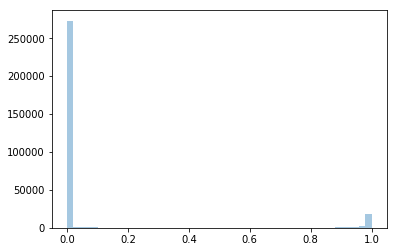

In [32]:
sns.distplot((torch.sigmoid(torch.tensor(predictions_raw))).numpy(),kde=False, hist=True, rug=False)

In [33]:
# for individual question sentence pairs
wrong_prediction_indices = []
correct_prediction_indices = []
for i in range(len(dataset["supporting_fact"])):
    if( dataset["supporting_fact"][i] != pred_answer_labels[i]):
        wrong_prediction_indices.append(i)
    else:
        correct_prediction_indices.append(i)

In [34]:
len(wrong_prediction_indices)

11791

In [35]:
len(correct_prediction_indices)

294632

In [36]:
def get_q_s_pair(index, dataset):
    token_ids = dataset["sequences"][index]
    true_label = dataset["supporting_fact"][index]
    words = tokenizer.convert_ids_to_tokens(token_ids)
    return {"sequence":" ".join(words),"true_label":true_label} 

def sort_indices_increasing_confidence(indices, scores, threshold):
    margins = []
    for index in indices:
        m = scores[index] - threshold
        margins.append(m)
    return np.argsort(np.absolute(margins)), np.absolute(margins)
        

In [37]:
print(get_q_s_pair(wrong_prediction_indices[1], dataset))

{'sequence': '[CLS] what science fantasy young adult series , told in first person , has a set of companion books na ##rra ##ting the stories of enslaved worlds and alien species ? [SEP] the ho ##rk - ba ##ji ##r chronicles is the second companion book to the " an ##imo ##rp ##hs " series , written by k . a . apple ##gate . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'true_label': 1}


### Least and most confident wrong predictions

In [38]:
sigmoid_scores = (torch.sigmoid(torch.tensor(predictions_raw))).numpy()

In [39]:
incorrect_confidences_sorted, incorrect_margins = sort_indices_increasing_confidence(wrong_prediction_indices, sigmoid_scores, threshold)

In [40]:
print(get_q_s_pair(wrong_prediction_indices[incorrect_confidences_sorted[0]], dataset))
print("margin: ",incorrect_margins[incorrect_confidences_sorted[0]])

{'sequence': '[CLS] what was the event where jacob mina ##h had his personal best also known as ? [SEP] jacob mina ##h ( born 3 april 1982 ) is a dec ##ath ##lete from germany . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'true_label': 0}
margin:  1.6319751739546362e-05


In [41]:
print(get_q_s_pair(wrong_prediction_indices[incorrect_confidences_sorted[-1]], dataset))
print("margin: ",incorrect_margins[incorrect_confidences_sorted[-1]])

{'sequence': '[CLS] which album came out first , " paper trail " or " if tomorrow comes . . . " ? [SEP] " live your life " is a song by american rapper t . i . , from his sixth studio album , " paper trail " ( 2008 ) , and features bar ##bad ##ian singer rihanna . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'true_label': 1}
margin:  0.9499479088291991


### Least and most confident correct predictions

In [42]:
correct_confidences_sorted, correct_margins = sort_indices_increasing_confidence(correct_prediction_indices, sigmoid_scores, threshold)

In [43]:
print(get_q_s_pair(correct_prediction_indices[correct_confidences_sorted[0]], dataset))
print("margin: ",correct_margins[correct_confidences_sorted[0]])

{'sequence': '[CLS] what year was george harrison \' s top uk charted song voted the nations 11th favorite 1980s number ? [SEP] in 1987 , george harrison released a cover version of the song as a single , and released it on his album , " cloud nine , " which he had recorded on his own dark horse records label . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'true_label': 0}
margin:  1.0383129119828638e-05


In [44]:
print(get_q_s_pair(correct_prediction_indices[correct_confidences_sorted[-1]], dataset))
print("margin: ",correct_margins[correct_confidences_sorted[-1]])

{'sequence': '[CLS] where was the world cup hosted that algeria qualified for the first time into the round of 16 ? [SEP] switzerland qualified for the european championship for the first time in 2017 . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'true_label': 0}
margin:  0.9499491751586902
